<h3>Model Evaluation</h3>

In [ ]:
'''
Evaluation of the original DANTE model
'''

"from google.colab import drive\n\ndrive.mount('/content/drive/')"

In [ ]:
#from model import InsiderClassifier, LSTM_Encoder, CNN_Classifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [ ]:
# This file contains the DANTE.v2 model definition (InsiderClassifier)

import torch
import torch.nn as nn
import torch.nn.functional as F

# Model Definition:

class LSTM_Encoder(nn.Module):
    def __init__(self, padding_idx=None, input_size=201, embedding_dim=40, lstm_hidden_size=40, num_layers=3, dropout_rate=0.5):
        super(LSTM_Encoder, self).__init__()

        # Model hyperparameters/constants
        self.input_size = input_size
        self.lstm_hidden_size = lstm_hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=padding_idx)
        lstm_input_size = embedding_dim

        # One-hot encoder fallback (optional)
        self.one_hot_encoder = F.one_hot

        # Core LSTM Encoder
        self.lstm_encoder = nn.LSTM(
            lstm_input_size,
            lstm_hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate,
            batch_first=True)

        self.dropout = nn.Dropout(dropout_rate)
        # Decoder maps hidden_size back to the input vocab size (input_size)
        self.decoder = nn.Linear(lstm_hidden_size, input_size)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, sequence):
        # sequence shape: (batch_size, seq_len)

        # 1. Input Processing (Embedding or One-Hot)
        if self.embedding:
            x = self.embedding(sequence)
        else:
            x = self.one_hot_encoder(sequence,
                num_classes=self.input_size).float()
        # x shape: (batch_size, seq_len, embed_dim)

        # 2. LSTM Forward Pass
        x, _ = self.lstm_encoder(x)
        # x shape: (batch_size, seq_len, lstm_hidden_size)

        # 3. Output for Training (Reconstruction) or Inference (Hidden State)
        if self.training:
            x = self.dropout(x)
            x = self.decoder(x)
            x = self.log_softmax(x)
            # Output for reconstruction loss: (batch_size, seq_len, input_size)
            return x
        else:
            # Output for Classifier: (batch_size, seq_len, lstm_hidden_size)
            return x


class CNN_Classifier(nn.Module):
    def __init__(self, seq_length=200, lstm_hidden_size=40):
        super(CNN_Classifier, self).__init__()

        self.seq_length = seq_length
        self.lstm_hidden_size = lstm_hidden_size

        final_seq_dim = self.seq_length // 4
        final_hidden_dim = self.lstm_hidden_size // 4

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)

        # Calculate the required linear input size dynamically
        linear_input_size = 64 * final_seq_dim * final_hidden_dim

        self.flatten = lambda x: x.view(x.size(0),-1)
        self.linear = nn.Linear(linear_input_size, 2) # Output 2 classes (malicious/not malicious)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear(x)

        return x

class InsiderClassifier(nn.Module):
    def __init__(self, lstm_checkpoint, device='cuda'):
        super(InsiderClassifier, self).__init__()

        # Assuming similar architecture as in the original code:
        lstm_hidden_size = 40
        seq_length = 200 # Adjusted (max_length=250)

        self.lstm_encoder = LSTM_Encoder(lstm_hidden_size=lstm_hidden_size)
        self.lstm_encoder.requires_grad = False
        self.lstm_encoder.eval()
        self.load_encoder(lstm_checkpoint, device=device) # Pass device here!

        self.sigmoid = nn.Sigmoid()
        self.cnn_classifier = CNN_Classifier(seq_length=seq_length, lstm_hidden_size=lstm_hidden_size)

        # Move the entire model to the correct device upon initialization
        self.to(device)

    def train(self, mode=True):
        # Only the CNN classifier is trained, the encoder stays in eval mode
        self.training = mode
        self.sigmoid.train(mode)
        self.cnn_classifier.train(mode)

        # Crucially, the encoder MUST remain in evaluation mode and have grad disabled.
        self.lstm_encoder.eval()
        self.lstm_encoder.requires_grad = False
        return self

    def load_encoder(self, checkpoint, device):
        # Map location ensures the checkpoint is loaded correctly regardless of current device
        self.lstm_encoder.load_state_dict(
            torch.load(
                checkpoint,
                map_location=torch.device(device)),
            strict=True
            )
        # Move the encoder to the target device after loading its state
        self.lstm_encoder.to(device)
        return self

    def forward(self, x):
        # Ensure input data is on the same device as the model
        device = next(self.parameters()).device
        x = x.to(device)

        with torch.no_grad():
            # The encoder is on the correct device due to __init__ and load_encoder
            hidden_state = self.lstm_encoder(x)
            hidden_state = self.sigmoid(hidden_state)

        # hidden_state shape: (batch_size, seq_len, lstm_hidden_size)
        # CNN expects (N, C, H, W). We add the channel dimension (C=1)
        scores = self.cnn_classifier(hidden_state.unsqueeze(1))

        return scores


Dataset

In [ ]:
class InsiderThreatDataset(Dataset):
    def __init__(self, X_path, y_path):
        self.X = pd.read_pickle(X_path)
        self.y = pd.read_pickle(y_path)

        # Convert to Tensors: X must be Long (for nn.Embedding input), y must be Float
        self.X = torch.tensor(self.X.tolist(), dtype=torch.long)
        # Unsqueeze(1) makes labels (N, 1) for standard binary classification
        self.y = torch.tensor(self.y.values.astype(float), dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Evaluation Method

In [ ]:
BATCH_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_model(X_SUBSET_PATH, Y_SUBSET_PATH, MODEL_WEIGHTS_PATH, LSTM_CHECKPOINT_PATH='kkogDANTE'):
    # ------------------------------------
    # 1. Initialization and Data Loading
    # ------------------------------------
    current_device = torch.device(DEVICE)
    print(f"Starting evaluation on device: {current_device}")

    # Load subset dataset
    subset_dataset = InsiderThreatDataset(X_SUBSET_PATH, Y_SUBSET_PATH)
    dataloader = DataLoader(
        subset_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False, # Don't shuffle for evaluation
        num_workers=0  # Safe mode for evaluation
    )

    # ------------------------------------
    # 2. Model Loading
    # ------------------------------------

    # Instantiate the model architecture
    model = InsiderClassifier(
        lstm_checkpoint=LSTM_CHECKPOINT_PATH,
        device=current_device
    )

    # Load the trained CNN weights from model.pkl
    try:
        # Load the state dictionary
        state_dict = torch.load(MODEL_WEIGHTS_PATH, map_location=current_device)

        # Load the state dictionary into the instantiated model
        model.load_state_dict(state_dict)
        print(f"Successfully loaded weights from {MODEL_WEIGHTS_PATH}")
    except FileNotFoundError:
        print(f"Error: Model weights file not found at {MODEL_WEIGHTS_PATH}")
        print("Please ensure 'model.pkl' is in the current directory.")
        return
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return

    # Set the model to evaluation mode (disables dropout, preserves frozen encoder)
    model.eval()

    # ------------------------------------
    # 3. Inference and Prediction
    # ------------------------------------
    all_predictions = []
    all_labels = []
    start_time = time.perf_counter() # start timer

    print("Running inference...")
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            # Move data to device
            X_batch = X_batch.to(current_device)

            # Forward pass (scores are log-probabilities)
            scores = model(X_batch)

            # Get the predicted class index (0 or 1)
            # torch.max returns (values, indices). We want the indices.
            _, predicted_classes = torch.max(scores, 1)

            # Append results: predicted classes (CPU) and true labels (CPU)
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(y_batch.long().squeeze(1).cpu().numpy())

    end_time = time.perf_counter() # end timer

    # ------------------------------------
    # 4. Calculate Accuracy
    # ------------------------------------

    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_predictions)

    accuracy = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])

    print("\n======================================")
    print(f"EVALUATION COMPLETE on {len(true_labels)} samples")

    print(f"Accuracy Score (sklearn): {accuracy:.4f}")
    print(f"Precision Score (sklearn): {prec:.4f}")
    print(f"Recall Score (sklearn): {rec:.4f}")

    print("F1: ", f1_score(true_labels, predicted_labels))
    print(f"\nTime taken for inference: {end_time - start_time} seconds")

    # displaying the confusion matrix
    print("\nConfusion Matrix:\n")

    disp.plot()
    plt.show()

    print("\n======================================")


Evaluation on Test Set

Starting evaluation on device: cuda
Successfully loaded weights from ogDANTE_logsoft.pkl
Running inference...

EVALUATION COMPLETE on 37382 samples
Accuracy Score (sklearn): 0.9978
Precision Score (sklearn): 0.0500
Recall Score (sklearn): 0.0152
F1:  0.023255813953488372

Time taken for inference: 3.36504886299997 seconds

Confusion Matrix:



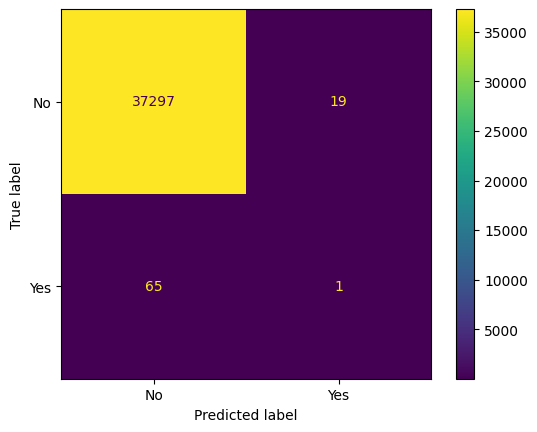

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_test_ogDANTE.pkl', Y_SUBSET_PATH = 'y_test_ogDANTE.pkl', MODEL_WEIGHTS_PATH = 'ogDANTE_logsoft.pkl', LSTM_CHECKPOINT_PATH='kkogDANTE')

Evaluation on Scenario 1

Starting evaluation on device: cuda
Successfully loaded weights from ogDANTE_logsoft.pkl
Running inference...

EVALUATION COMPLETE on 2105 samples
Accuracy Score (sklearn): 0.9976
Precision Score (sklearn): 0.0000
Recall Score (sklearn): 0.0000
F1:  0.0

Time taken for inference: 0.2027926219999472 seconds

Confusion Matrix:



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


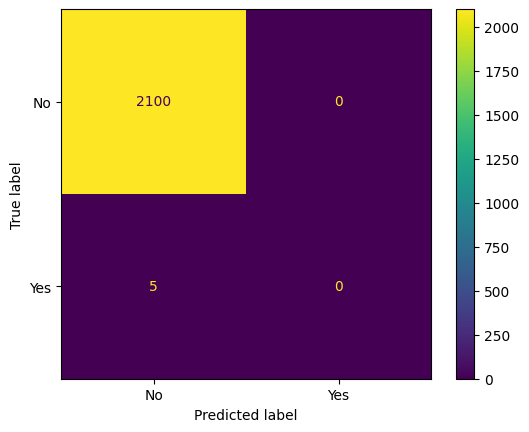

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_S1_ogDANTE.pkl', Y_SUBSET_PATH = 'y_S1_ogDANTE.pkl', MODEL_WEIGHTS_PATH = 'ogDANTE_logsoft.pkl', LSTM_CHECKPOINT_PATH='kkogDANTE')

Evaluation on Scenario 2

Starting evaluation on device: cuda
Successfully loaded weights from ogDANTE_logsoft.pkl
Running inference...

EVALUATION COMPLETE on 2503 samples
Accuracy Score (sklearn): 0.9461
Precision Score (sklearn): 0.0000
Recall Score (sklearn): 0.0000
F1:  0.0

Time taken for inference: 0.28137879299993074 seconds

Confusion Matrix:



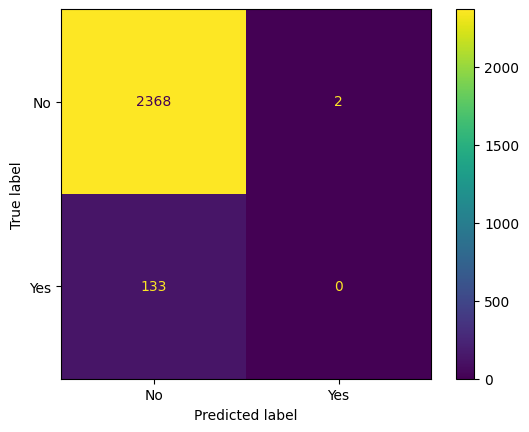

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_S2_ogDANTE.pkl', Y_SUBSET_PATH = 'y_S2_ogDANTE.pkl', MODEL_WEIGHTS_PATH = 'ogDANTE_logsoft.pkl', LSTM_CHECKPOINT_PATH='kkogDANTE')

Evaluation on Scenario 3

Starting evaluation on device: cuda
Successfully loaded weights from ogDANTE_logsoft.pkl
Running inference...

EVALUATION COMPLETE on 1110 samples
Accuracy Score (sklearn): 0.9982
Precision Score (sklearn): 0.0000
Recall Score (sklearn): 0.0000
F1:  0.0

Time taken for inference: 0.13176589099998637 seconds

Confusion Matrix:



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


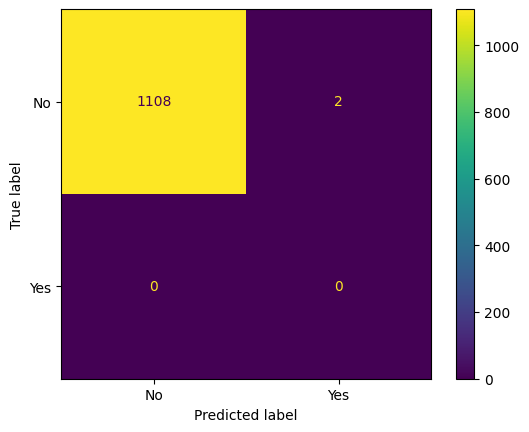

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_S3_ogDANTE.pkl', Y_SUBSET_PATH = 'y_S3_ogDANTE.pkl', MODEL_WEIGHTS_PATH = 'ogDANTE_logsoft.pkl', LSTM_CHECKPOINT_PATH='kkogDANTE')

Evaluation on Scenario 4

Starting evaluation on device: cuda
Successfully loaded weights from ogDANTE_logsoft.pkl
Running inference...

EVALUATION COMPLETE on 2924 samples
Accuracy Score (sklearn): 0.9340
Precision Score (sklearn): 0.4667
Recall Score (sklearn): 0.0365
F1:  0.06763285024154589

Time taken for inference: 0.3387971650000736 seconds

Confusion Matrix:



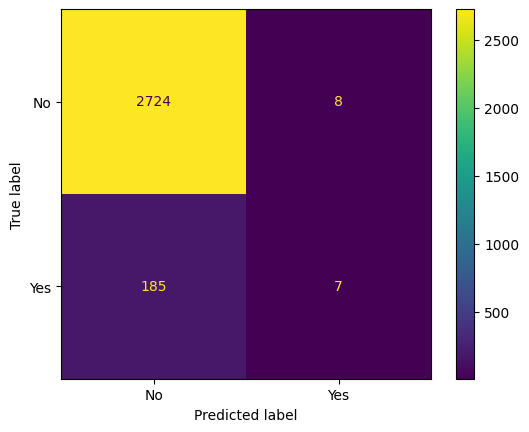

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_S4_ogDANTE.pkl', Y_SUBSET_PATH = 'y_S4_ogDANTE.pkl', MODEL_WEIGHTS_PATH = 'ogDANTE_logsoft.pkl', LSTM_CHECKPOINT_PATH='kkogDANTE')